In [1]:
import os
import pandas as pd
import random

import sys
sys.path.insert(0, '..')

from unpast.run_unpast import unpast
from unpast.utils.method import prepare_input_matrix
from unpast.utils.consensus import make_consensus_biclusters

### Input and output

This example uses expressions of 200 randomly chosen samples from the TCGA-BRCA dataset (normalized and standardized log2(x+1) RNA-seq counts)

In [2]:
# input .tsv file; features in rows, samples in columns
exprs_file = "test_data_TCGA200/TCGA_200.exprs_z.tsv" 

if not os.path.exists(exprs_file):
    from gdown import download
    from zipfile import ZipFile

    url = 'https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN'
    output = 'TCGA200_example.zip'
    download(url, output, quiet=False)

    with ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()

    os.remove(output)

# or download and unzip it manually: https://drive.google.com/file/d/1zee_GssqXCv_-tokLRJKR8cLksxsa8UN/view?usp=drive_link# input .tsv file; features in rows, samples in columns

In [3]:
# specify output folder and output file prefix
basename = 'TCGA200'
out_dir = "TCGA200_example/"

### Run UnPaSt 

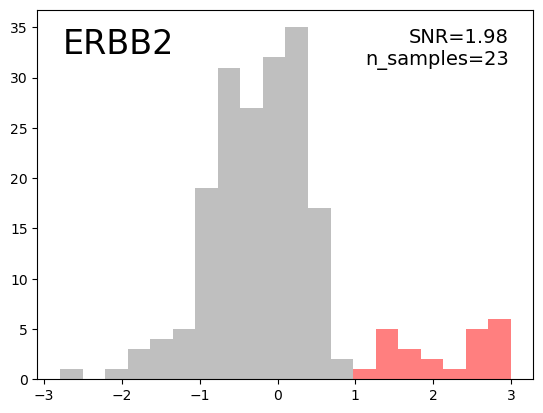

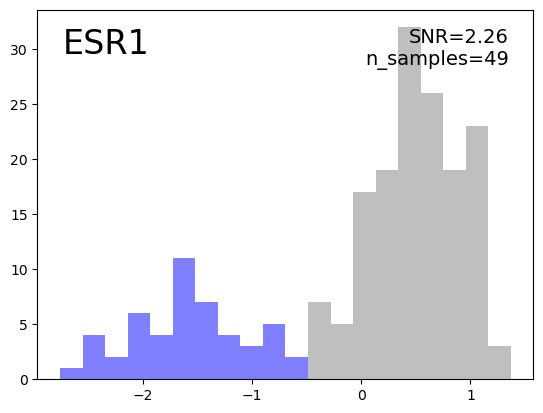

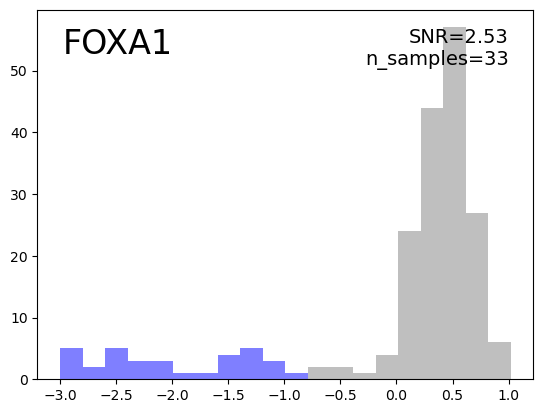

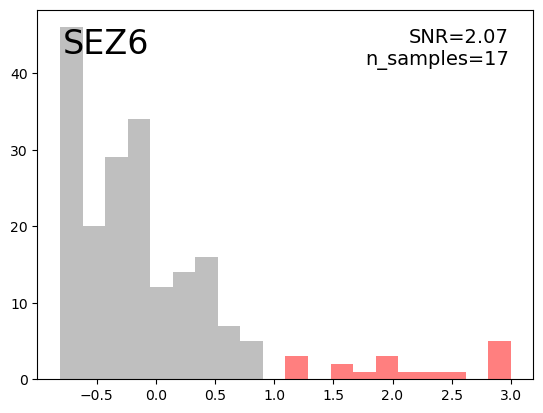

In [4]:
results = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            # optional: show distributions of some selected features
            # known subtype-specific biomarkers are chosen in this example
            show_fits = ["ERBB2","ESR1","FOXA1","SEZ6"],
            seed = 42
            )

In [5]:
results.head(2)

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
0,3.528302,39,37,"{CMBL, MLPH, MYB, FBP1, ANKRD30A, TTC6, KCNJ11...","{TCGA-BH-A0AV-01, TCGA-B6-A0X1-01, TCGA-A7-A26...",DOWN,{},"{CMBL, MYB, MLPH, FBP1, ANKRD30A, TTC6, KCNJ11...","{1923, 388, 9990, 3847, 7176, 11795, 11159, 38...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."
1,2.453225,157,38,"{CA9, EPHX4, PAPL, UNC93A, SOX11, ATL2, KCNK5,...","{TCGA-BH-A0AV-01, TCGA-B6-A0X1-01, TCGA-A7-A26...",UP,"{CA9, EPHX4, PAPL, UNC93A, SOX11, ATL2, KCNK5,...",{},"{7681, 12290, 9729, 3077, 1035, 7695, 1553, 20...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."


### Re-run UnPaSt using previously computed binarization results

add `load = True`

In [6]:
results2 = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            load= True, # try loading precomputed binarization results
            seed = 42
            )

### Read and write UnPaSt results

In [7]:
from unpast.utils.io import write_bic_table, read_bic_table

In [8]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True"
seed = 42
bic_file = out_dir + "/"+basename+".seed="+str(seed)+suffix+".biclusters.tsv"
biclusters = read_bic_table(bic_file)
biclusters.head(2)

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
id,,,,,,,,,,
0,3.528302,39,37,"{CMBL, MLPH, MYB, FBP1, ANKRD30A, TTC6, KCNJ11...","{TCGA-BH-A0AV-01, TCGA-B6-A0X1-01, TCGA-A7-A26...",DOWN,{},"{CMBL, MLPH, MYB, FBP1, ANKRD30A, TTC6, KCNJ11...","{1923, 388, 9990, 3847, 7176, 11795, 11159, 38...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 147..."
1,2.453225,157,38,"{CA9, EPHX4, PAPL, UNC93A, SOX11, ATL2, KCNK5,...","{TCGA-BH-A0AV-01, TCGA-B6-A0X1-01, TCGA-A7-A26...",UP,"{CA9, EPHX4, PAPL, UNC93A, SOX11, ATL2, KCNK5,...",{},"{9729, 12290, 7681, 3077, 1035, 7695, 1553, 20...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 147..."


In [9]:
new_file_name = "TCGA200_example/TCGA200.biclusters.tsv"
write_bic_table(biclusters,new_file_name)

### Consensus biclusters from 5 runs

#### 1. Running UnPaSt five times with different seeds

* biclusters from individual runs:

\<basename>.seed=\<seed>.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [10]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [11]:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                  out_dir=out_dir,
                  load=False,
                  seed = seed
                 )
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 117


#### 2. Combine the results of five independent runs to consensus biclusters

* consensus biclusters:

TCGA200.consensus_seed=0.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [116]:
exprs = pd.read_csv(exprs_file,sep="\t",index_col = 0)

# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
consensus_biclusters = make_consensus_biclusters(biclusters, exprs_z, 
                                                seed = analysis_seed,
                                                verbose = True,
                                                plot = False
                                                )

consensus_biclusters.head(3)

10 s for similarity matrix
	Running Louvain ...
		modularity: newman
modularity 0.9789327780091628
modularity 0.9890944108617303
modularity 0.9905722986101627
modularity 0.9906148165695531
modularity 0.9905386450377567
modularity 0.990510083570675
modularity 0.9905895474096156
modularity 0.9909213184698485
modularity 0.9912171234825298
modularity 0.9913592868381077
modularity 0.9914463452566096
modularity 0.9920923256668767
	curve type: increasing
	Louvain runtime: modules detected in 0.16 s.
	modules: 141, not clustered features 74 
		similarity cutoff: 0.43 modularity: 0.991
keep genes included in at least 2 merged biclusters


sknetwork version used: 0.33.0
/tmp/ipykernel_204192/2119029703.py:28: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


all consensus biclusters: 220
detected 2+ times:136
2 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,2.922866,155,36,"{EPHX4, DMRTA2, CA6, LDHC, MDGA2, RASGEF1C, DP...","{TCGA-E9-A244-01, TCGA-A1-A0SO-01, TCGA-E2-A1I...","{EPHX4, DMRTA2, CA6, LDHC, MDGA2, RASGEF1C, DP...","{MYB, XBP1, SIDT1, CYP4Z2P, PRR15, GATA3, TTC6...","{9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...",BOTH,7,"{seed=403958_0, seed=441001_0, seed=933488_3, ..."
1,2.763514,2,14,"{ISY1-RAB43, LUC7L2}","{TCGA-B6-A0I1-01, TCGA-AN-A0FT-01, TCGA-AO-A12...",{},"{ISY1-RAB43, LUC7L2}","{6282, 7263}","{193, 69, 70, 166, 168, 110, 19, 52, 179, 86, ...",DOWN,2,"{seed=885440_26, seed=933488_1}"
2,2.674523,7,24,"{KRT9, DMRT1, EN1, PAPL, TLX3, IGSF23, NCAN}","{TCGA-E9-A244-01, TCGA-A2-A0T0-01, TCGA-BH-A5I...","{KRT9, DMRT1, NCAN, EN1, PAPL, TLX3, IGSF23}",{},"{6080, 12997, 8261, 6792, 4019, 9012, 3546}","{131, 7, 139, 12, 13, 145, 19, 147, 157, 36, 1...",UP,7,"{seed=794772_4, seed=794772_7, seed=403958_6, ..."


In [113]:
import numpy as np
from time import time

from scipy.stats import chi2_contingency
from fisher import pvalue

import matplotlib.pyplot as plt

from unpast.utils.method import cluster_samples, update_bicluster_data
from unpast.utils.eval import find_best_matching_biclusters

def make_consensus_biclusters(
    biclusters_list,
    exprs,
    similarity="samples",  # can be 'both','genes','samples'
    p=0.05,  # bicluster overlap significance threshold
    min_similarity=1 / 3,  # minimal Jaccard similarity
    max_similarity=0.9,  # maximal Jaccard similarity
    frac_runs=1 / 3,
    min_n_genes=2,
    min_n_samples=5,
    min_n_times_detected=2,
    modularity_measure="potts",
    method="kmeans",  # sample clustering method
    seed=-1,
    plot=False,
    figsize=(7, 7),
    labels=False,
    colorbar_off=True,
    verbose=True,
):
    # considers only significantly overlapping and best matching bicluster pairs
    # list of biclusters from several runs
    n_runs = len(biclusters_list)
    if n_runs < min_n_times_detected:
        print(
            "The number of biclusterins results should be not less than min_n_times_detected=%s"
            % (min_n_times_detected),
            file=sys.stderr,
        )
        return

    t0 = time()
    N = exprs.shape[0]
    
    if seed == -1:
        seed = random.randint(0, 1000000)
        print("Seed for sample clustering: %s" % (seed), file=sys.stderr)

    for i in range(n_runs):
        biclusters_list[i]["run"] = i
    biclusters = pd.concat(biclusters_list)
    bic_ids = biclusters.index.values
    biclusters["detected_n_times"] = 1

    n_bics = biclusters.shape[0]
    J_heatmap = pd.DataFrame(np.zeros((n_bics, n_bics)), index=bic_ids, columns=bic_ids)

    # add only best matches to Jaccard similarity matrix
    avg_J_sim = {}
    for i in range(n_runs):
        # bicluster is always the best match of itself,
        # similarity matrix block for output of a biclustering method w. itself is an identity matrix
        bics1 = biclusters.loc[biclusters["run"] == i, :]
        J_heatmap.loc[bics1.index.values, bics1.index.values] = np.identity(
            bics1.shape[0]
        )
        avg_J_sim[i] = {i: 1}
        for j in range(n_runs):
            if i != j:
                bics2 = biclusters.loc[biclusters["run"] == j, :]
                # find best matches between bics1 and bics2
                bm = find_best_matching_biclusters(
                    bics1,
                    bics2,
                    exprs.shape,
                    by=similarity,
                    min_g=min_n_genes,
                    adj_pval_thr=p,
                )
                bm = bm.dropna()
                if bm.shape[0] > 0:
                    avg_J_sim[i][j] = np.mean(bm["J"])
                    df = bm.loc[:, ["bm_id", "J"]]
                    for row in df.iterrows():
                        J_heatmap.loc[row[0], row[1]["bm_id"]] += row[1]["J"] / 2
                        J_heatmap.loc[row[1]["bm_id"], row[0]] += row[1]["J"] / 2

    
    # if all biclusters are exactly the same
    if J_heatmap.min().min() == 1:
        # return the first bicluster
        consensus_biclusters = biclusters.iloc[[0], :].copy()
        consensus_biclusters.index = [0]
        consensus_biclusters.loc[0, "detected_n_times"] = biclusters.shape[0]
        print("all biclusters are exactly the same", file=sys.stderr)
        return consensus_biclusters
    
    # plot bicluster similarity heatmaps
    if plot:
        import seaborn as sns

        avg_J_sim = pd.DataFrame.from_dict(avg_J_sim)
        avg_J_sim = avg_J_sim.fillna(0)
        if avg_J_sim.shape[0] > 0:
            g = sns.clustermap(
                avg_J_sim,
                linewidths=0,
                vmin=0,
                vmax=1,
                figsize=(3, 3),
                center=0,
                annot=True,
            )
            g.ax_cbar.set_visible(False)
            plt.show()

        labels = True
        if len(bic_ids) > 20:
            labels = False
        g = sns.clustermap(
            J_heatmap,
            yticklabels=labels,
            xticklabels=labels,
            linewidths=0,
            vmin=0,
            vmax=1,
            figsize=figsize,
            center=0,
            annot=labels,
        )
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        if colorbar_off:
            g.cax.set_visible(False)
        plt.show()

    t1 = time()
    if verbose:
        print("%s s for similarity matrix" % round(t1 - t0))

    #return J_heatmap, np.arange(min_similarity, max_similarity, 0.05),modularity_measure
    # cluster biclusters by similarity
    matched, not_matched, cutoff = run_Louvain(
        J_heatmap,
        similarity_cutoffs=np.arange(min_similarity, max_similarity, 0.05),
        m=False,
        verbose=verbose,
        plot=plot,
        modularity_measure=modularity_measure,
    )
    t2 = time()

    # make consensus biclusters
    # for each group of matched biclusters, select consensus gene set
    # keep genes occuring at least 'min_n_times_detected' times
    min_n_times_detected= max(min_n_times_detected,int(frac_runs*n_runs))
    if verbose:
        print("keep genes included in at least %s merged biclusters" % round(min_n_times_detected))
        
    consensus_biclusters = []
    # for each group of matched biclusters
    for i in range(len(matched)):
        gsets = biclusters.loc[matched[i], "genes"].values
        bic_ids = biclusters.loc[matched[i], :].index.values
        detected_n_times = biclusters.loc[matched[i], "detected_n_times"].sum()
        # count gene occurencies
        gene_occurencies = {}
        for gene in set().union(*gsets):
            gene_occurencies[gene] = 0
            for gset in gsets:
                if gene in gset:
                    gene_occurencies[gene] += 1

        gene_occurencies = pd.Series(gene_occurencies).sort_values()
        passed_genes = sorted(
            gene_occurencies[
                gene_occurencies >= min(n_runs, len(matched)) * frac_runs
            ].index.values
        )
        not_passed_genes = sorted(
            gene_occurencies[
                gene_occurencies < min(n_runs, len(matched)) * frac_runs
            ].index.values
        )

        if len(passed_genes) < min_n_genes:
            # move all biclusters to not matched
            not_matched += list(matched[i])
        else:
            # cluster samples again in a subspace of a new gene set
            bicluster = cluster_samples(
                exprs.loc[passed_genes, :].T,
                min_n_samples=min_n_samples,
                seed=seed,
                method=method,
            )
            # if bicluster is not empty, add it to consenesus
            if "sample_indexes" in bicluster.keys():
                bicluster["genes"] = set(passed_genes)
                bicluster["n_genes"] = len(bicluster["genes"])
                bicluster = update_bicluster_data(bicluster, exprs)
                bicluster["detected_n_times"] = detected_n_times
                bicluster["ids"] = set(bic_ids) # ids of biclusters merged to the consensus biclusters
                consensus_biclusters.append(bicluster)
    consensus_biclusters = pd.DataFrame.from_records(consensus_biclusters)

    # add not matched
    not_changed_biclusters = biclusters.loc[not_matched, :]
    # not_changed_biclusters["detected_n_times"] = 1
    consensus_biclusters = pd.concat([consensus_biclusters, not_changed_biclusters])

    # add direction
    consensus_biclusters["direction"] = "BOTH"
    consensus_biclusters.loc[
        consensus_biclusters["n_genes"] == consensus_biclusters["genes_up"].apply(len),
        "direction",
    ] = "UP"
    consensus_biclusters.loc[
        consensus_biclusters["n_genes"]
        == consensus_biclusters["genes_down"].apply(len),
        "direction",
    ] = "DOWN"

    # sort
    col_order = [
        "SNR",
        "n_genes",
        "n_samples",
        "genes",
        "samples",
        "genes_up",
        "genes_down",
        "gene_indexes",
        "sample_indexes",
        "direction",
        "detected_n_times",
        "ids",
    ]
    consensus_biclusters = consensus_biclusters.sort_values(
        by=["SNR", "n_samples"], ascending=[False, True]
    )
    consensus_biclusters = consensus_biclusters.loc[:, col_order]
    consensus_biclusters = consensus_biclusters.loc[
        consensus_biclusters["n_samples"] >= min_n_samples, :
    ]
    if verbose:
        print("all consensus biclusters:", consensus_biclusters.shape[0])

    consensus_biclusters = consensus_biclusters.loc[
        consensus_biclusters["detected_n_times"] >= min_n_times_detected, :
    ]

    if verbose:
        print(
            "detected %s+ times:%s"
            % (min_n_times_detected, consensus_biclusters.shape[0])
        )

    consensus_biclusters.index = range(consensus_biclusters.shape[0])

    if verbose:
        print(
            round(time() - t2),
            "s for making consensus biclusters from consensus gene sets",
        )

    return consensus_biclusters


    # if sample size < max_N), use Fisher's exact
    # otherwise replacing exact Fisher's with chi2
    if overlap + group1_only + group2_only + background < max_N:
        pval = pvalue(overlap, group1_only, group2_only, background).right_tail
    else:
        chi2, pval, dof, expected = chi2_contingency(
            [[overlap, group1_only], [group2_only, background]]
        )
    return pval

# Example biclusters 

In [13]:
g = "ERBB2"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
34,1.708024,15,20,"{PGAP3, ADAM2, STARD3, PSMD3, AMIGO3, KRT24, D...","{TCGA-AC-A23C-01, TCGA-AR-A0TQ-01, TCGA-A8-A07...","{ADAM2, STARD3, PSMD3, AMIGO3, KRT24, DMRTC2, ...",{},"{3552, 14946, 12074, 12875, 11338, 9294, 12367...","{129, 132, 134, 149, 28, 29, 39, 46, 47, 54, 6...",UP,5,"{seed=441001_38, seed=403958_16, seed=794772_1..."


In [14]:
g = "ESR1"
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
3,2.472176,139,47,"{EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...","{TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...",{},"{EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...","{3596, 5647, 11795, 13331, 4117, 1558, 20, 719...","{128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...",DOWN,5,"{seed=933488_2, seed=441001_3, seed=403958_2, ..."


In [15]:
g = "FOXA1"
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,2.922866,155,36,"{INA, GSTA2, NR2E1, CLDN6, PRAME, PM20D2, FOXG...","{TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...","{INA, GSTA2, NR2E1, RBM38, CLDN6, PM20D2, FOXG...","{CAPN13, XBP1, FOXA1, FBP1, C9orf152, MYB, SLC...","{9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...",BOTH,7,"{seed=933488_0, seed=885440_0, seed=794772_1, ..."
3,2.472176,139,47,"{EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...","{TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...",{},"{EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...","{3596, 5647, 11795, 13331, 4117, 1558, 20, 719...","{128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...",DOWN,5,"{seed=933488_2, seed=441001_3, seed=403958_2, ..."


In [16]:
g = "SEZ6"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
28,1.734242,10,17,"{LRTM2, CPLX2, AMER3, PCSK2, CARTPT, SVOP, LIN...","{TCGA-E9-A54X-01, TCGA-EW-A2FR-01, TCGA-A2-A1F...","{LRTM2, CPLX2, AMER3, PCSK2, CARTPT, SVOP, LIN...",{},"{11392, 2913, 12579, 6442, 12523, 1875, 9140, ...","{33, 98, 35, 162, 134, 103, 168, 77, 17, 177, ...",UP,5,"{seed=933488_13, seed=441001_12, seed=403958_8..."
29,1.732302,3,25,"{KCNH6, SEZ6, AMER3}","{TCGA-BH-A0DI-01, TCGA-A1-A0SD-01, TCGA-E9-A3H...","{KCNH6, SEZ6, AMER3}",{},"{11392, 6442, 534}","{1, 130, 17, 20, 21, 150, 23, 151, 31, 33, 162...",UP,3,"{seed=885440_87, seed=794772_68, seed=403958_24}"


### Plot heatmap for selected biclusters
* Basal: 0,lightblue
* Her2+: 34,yellow
* Neuroendocrine: 28,orange

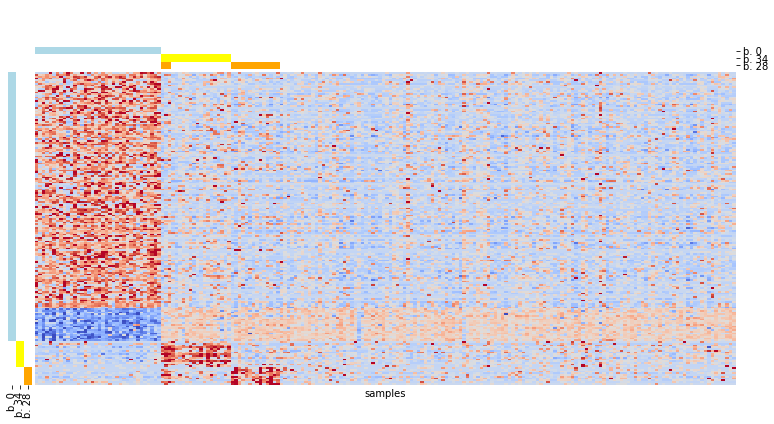

In [17]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import zscore

# select several biclusters to plot
# Basal: 0,lightblue; Her2+: 34,yellow; Neuroendocrine: 28,orange
i = [0,34,28] 
b = consensus_biclusters.loc[i,:]


tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors=["lightblue","yellow","orange"], # "auto",
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = False,
                no_row_colors = False,cluster_rows=False
             )